# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as mt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import Dropout
df = pd.read_csv("../input/air-traffic-passenger-statistics.csv")
df.head()

Using TensorFlow backend.


,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)  
import cufflinks as cf  
cf.go_offline() 

In [3]:
df.loc[:,"Activity Period"] = pd.to_datetime(df.loc[:,"Activity Period"].astype(str), format="%Y%m")
df.loc[:,"Year"] = df["Activity Period"].dt.year
df.loc[:,"Month"] = df["Activity Period"].dt.month

In [4]:
df.columns

Index(['Activity Period', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count', 'Year', 'Month'],
      dtype='object')

In [5]:
df.isna().sum()

Activity Period                 0
Operating Airline               0
Operating Airline IATA Code    63
Published Airline               0
Published Airline IATA Code    63
GEO Summary                     0
GEO Region                      0
Activity Type Code              0
Price Category Code             0
Terminal                        0
Boarding Area                   0
Passenger Count                 0
Year                            0
Month                           0
dtype: int64

Now since the Operting Airline IATA and Published Airline IATA codes are missisng, we will be using the original Airline names

# EDA

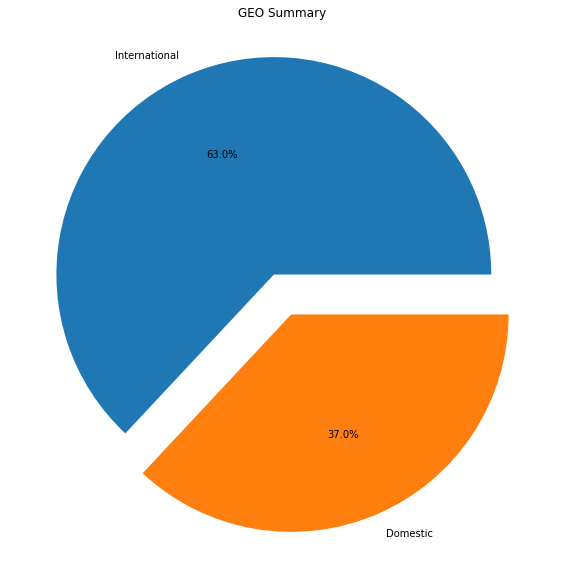

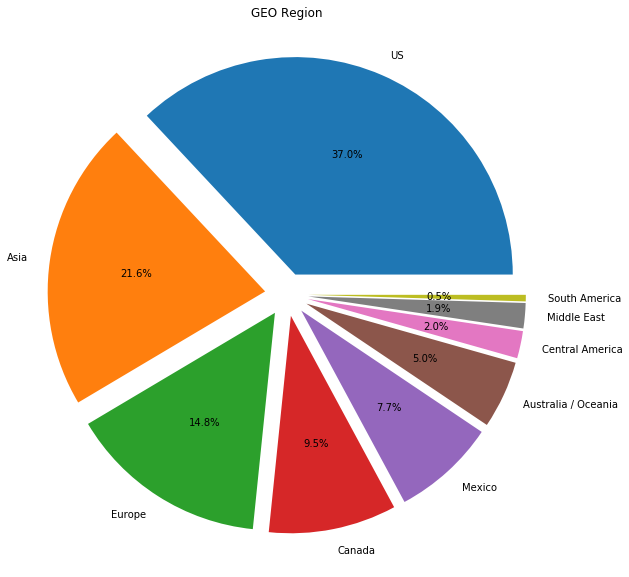

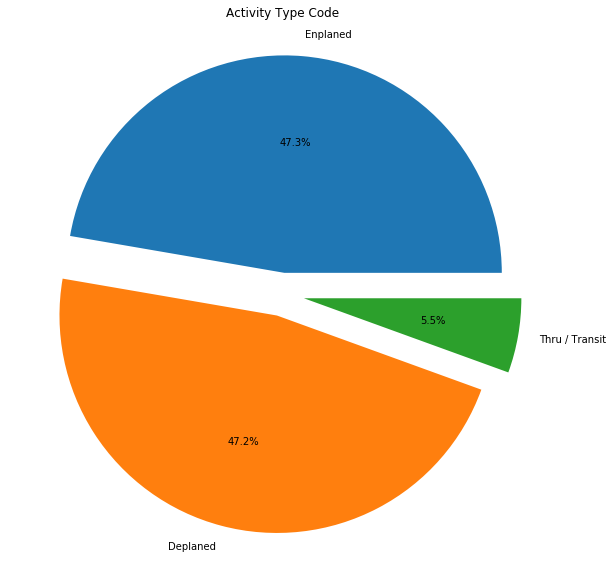

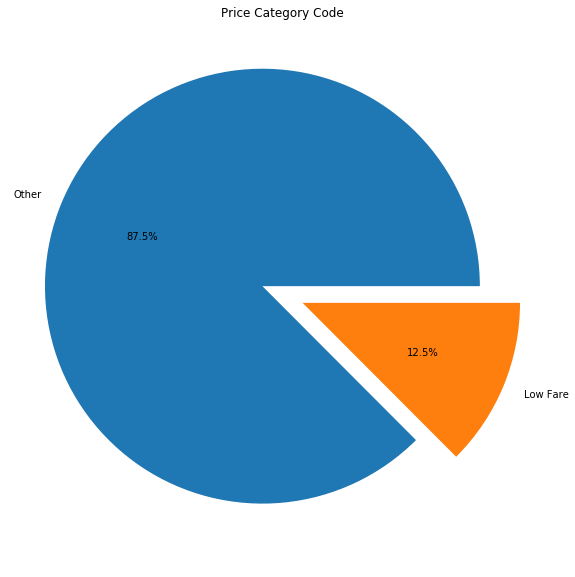

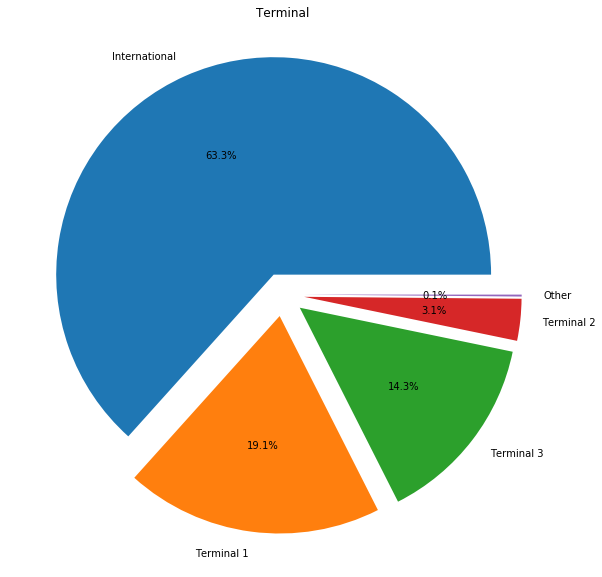

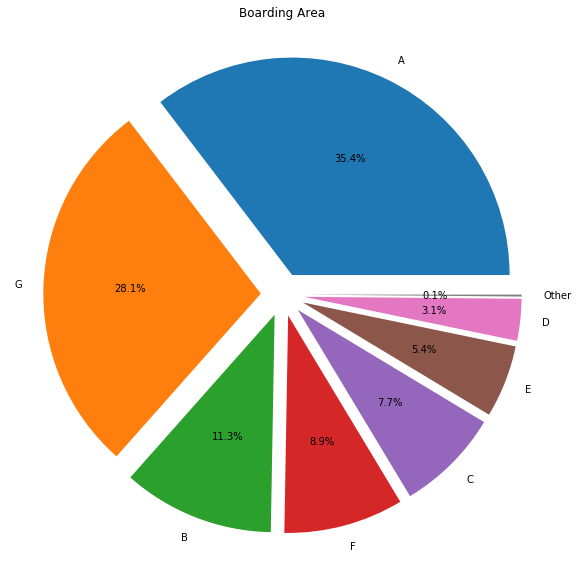

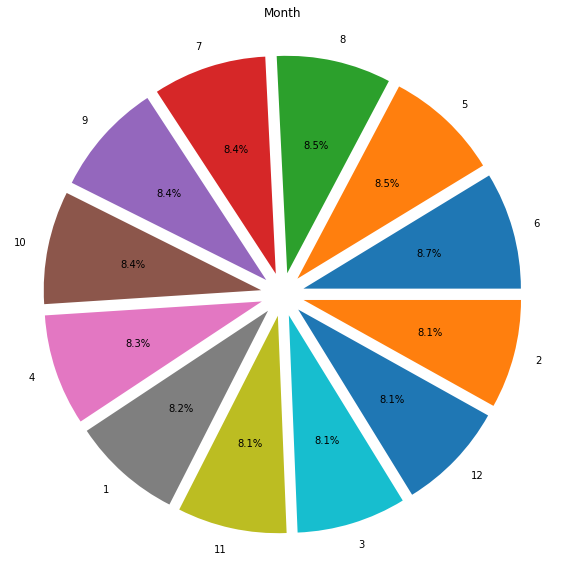

In [6]:
for i in ['GEO Summary','GEO Region','Activity Type Code','Price Category Code',
          'Terminal','Boarding Area','Month']:
    A = df[i].value_counts().index.tolist()
    Vals = list(pd.value_counts(df[i]))
    explode = [0.1]*len(A)
    plt.figure(figsize=(10,10))
    plt.title(i)
    plt.pie(Vals,explode=explode,labels=A,autopct='%.1f%%')
    plt.show()

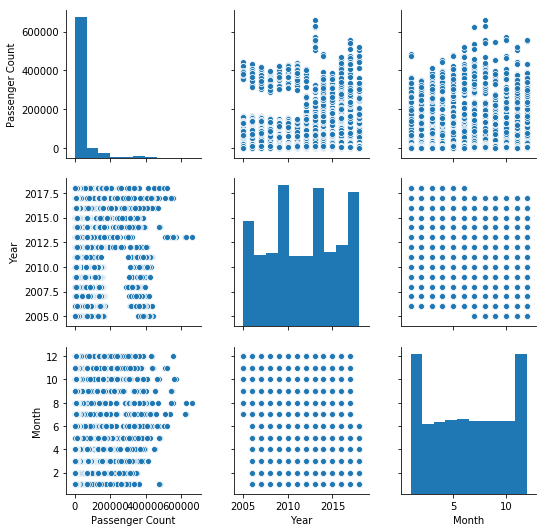

In [7]:
sns.pairplot(df.drop(['Operating Airline IATA Code','Published Airline IATA Code'],axis=1))

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



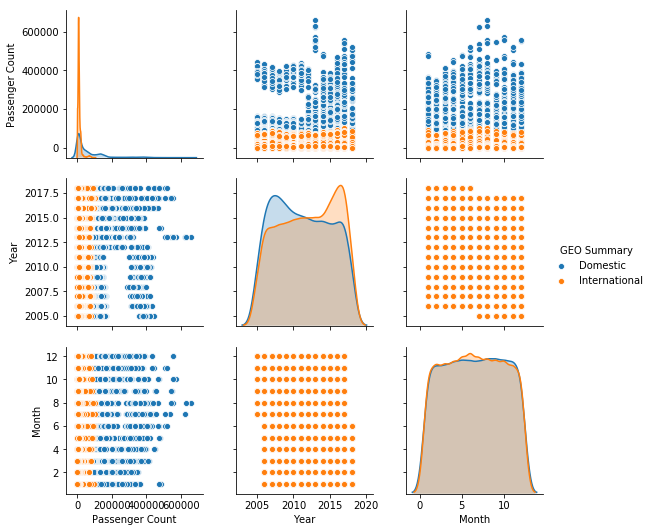

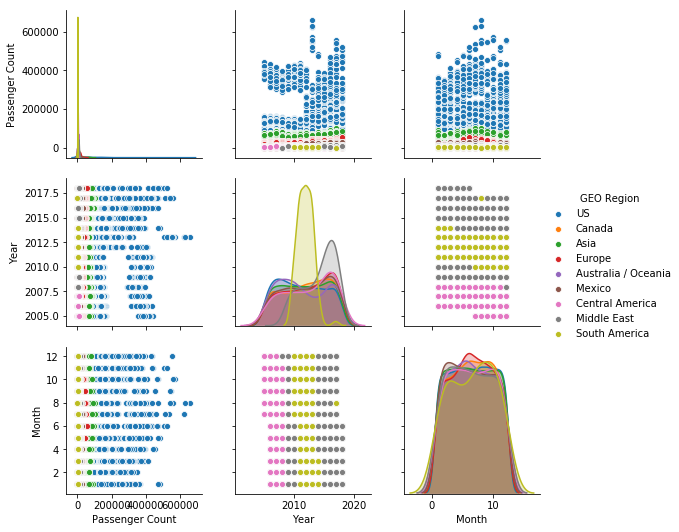

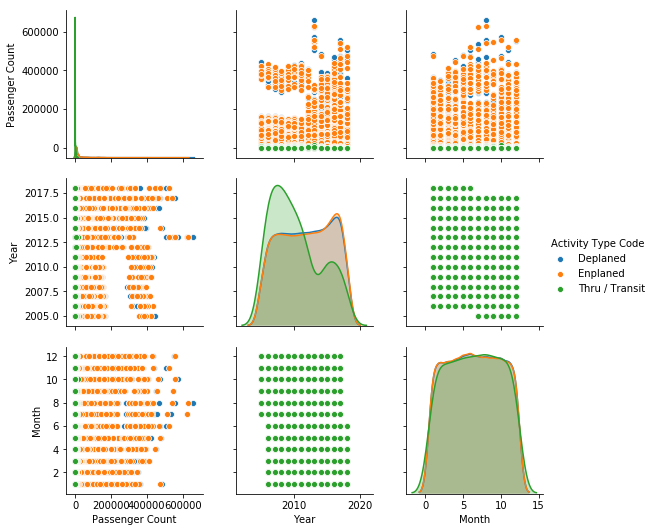

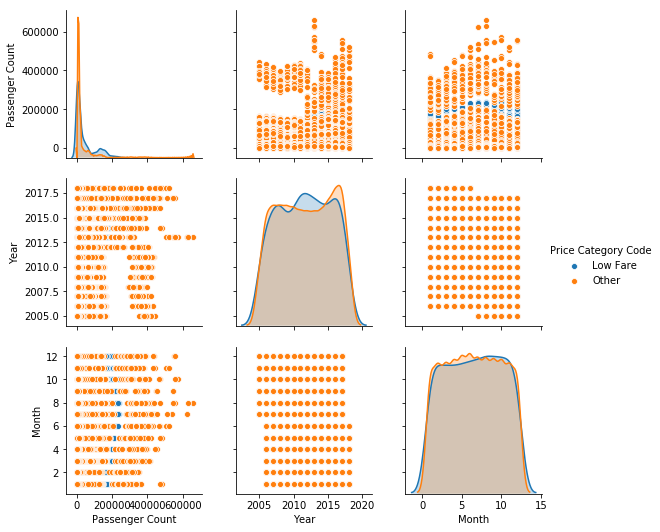

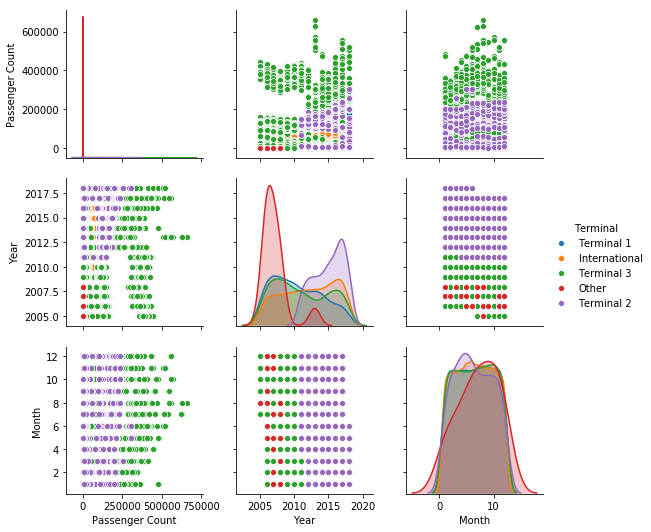

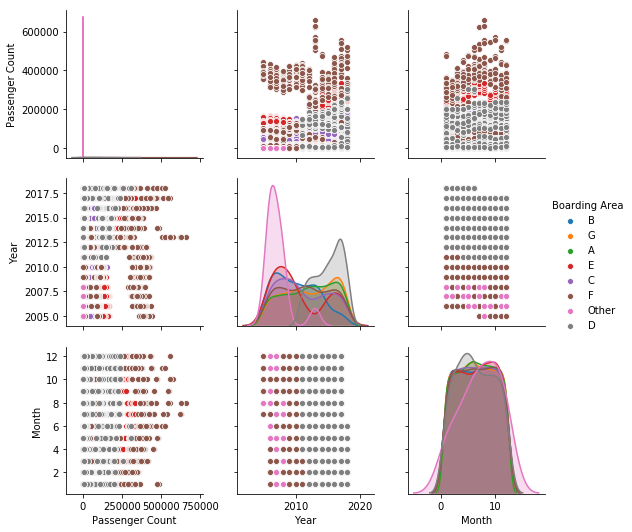

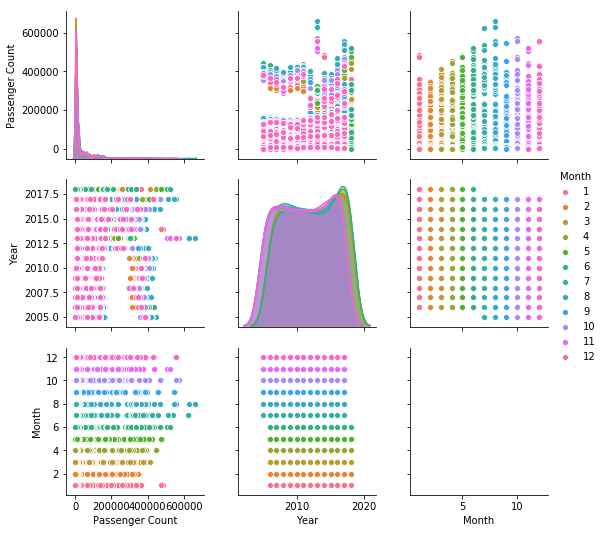

In [8]:
for i in ['GEO Summary','GEO Region','Activity Type Code','Price Category Code',
          'Terminal','Boarding Area','Month']:
    sns.pairplot(hue=i,data=df.drop(['Operating Airline IATA Code','Published Airline IATA Code'],axis=1))

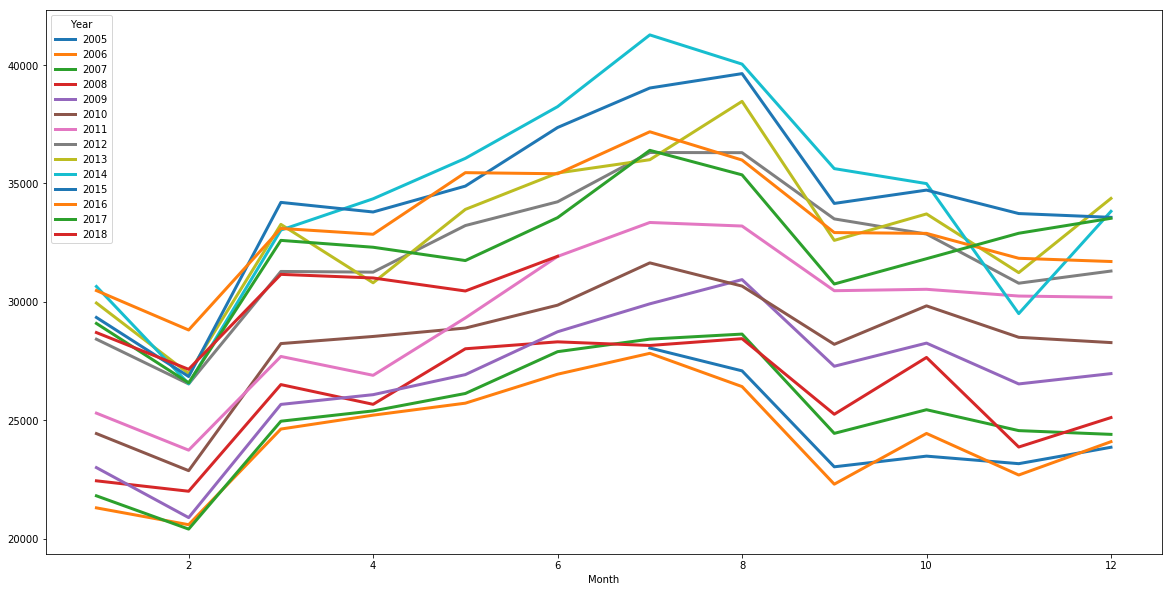

In [9]:
spivot = pd.pivot_table(df, index='Month', columns = 'Year', values = 'Passenger Count', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.show()

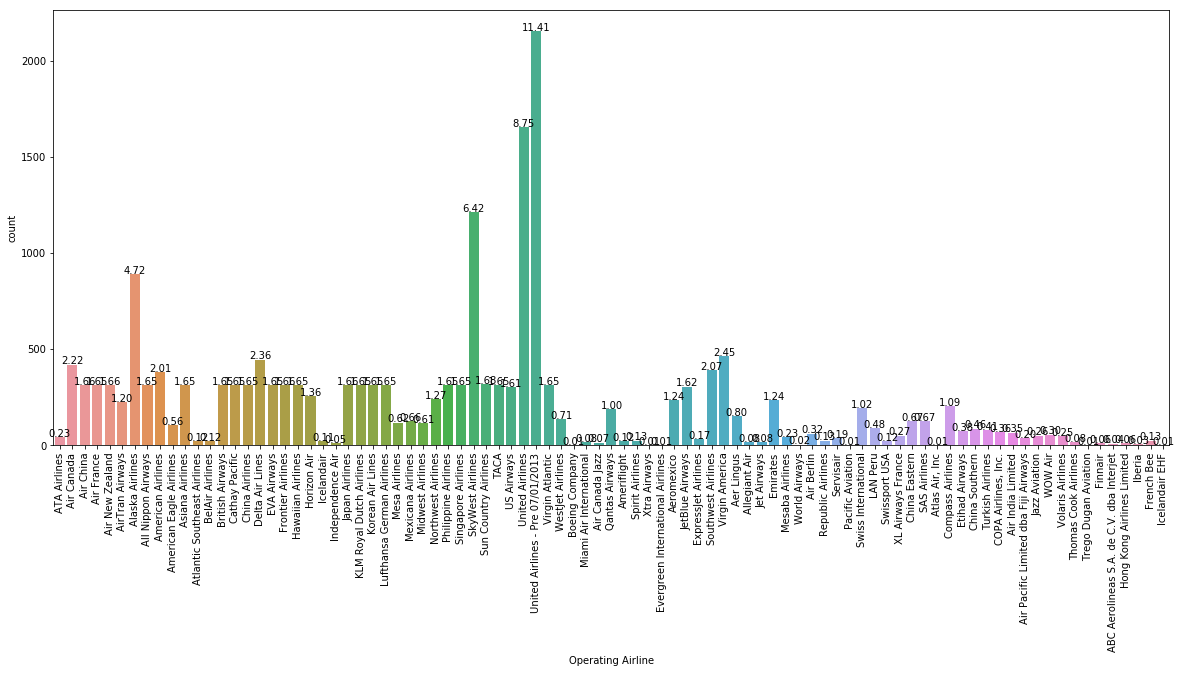

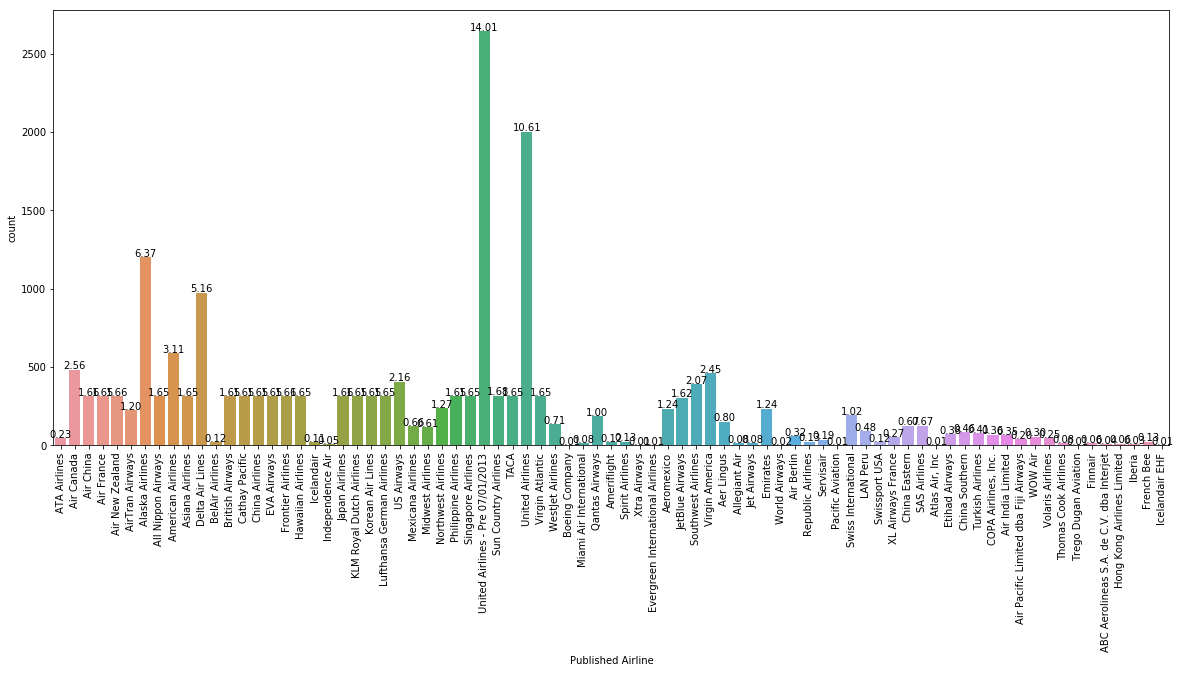

In [10]:
total = float(len(df))
for i in ['Operating Airline','Published Airline']:
    plt.figure(figsize=(20,8))
    plt.xticks(rotation=90)
    ax = sns.countplot(x=i, data=df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format((height/total)*100),ha="center") 
plt.show()

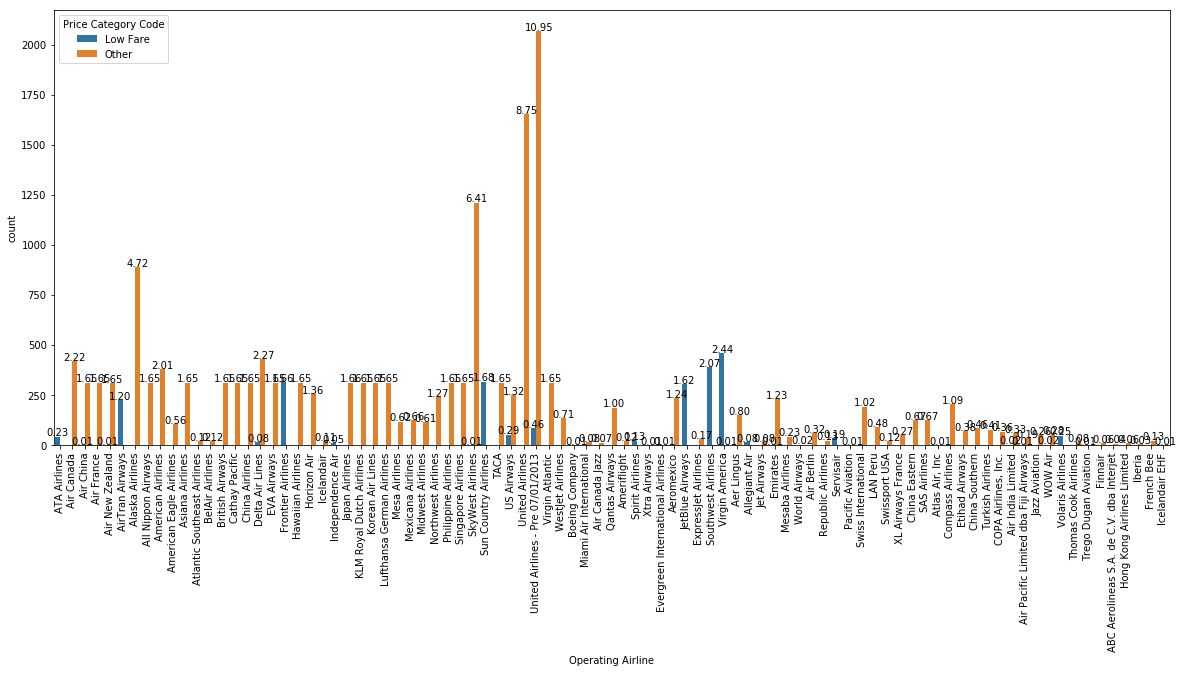

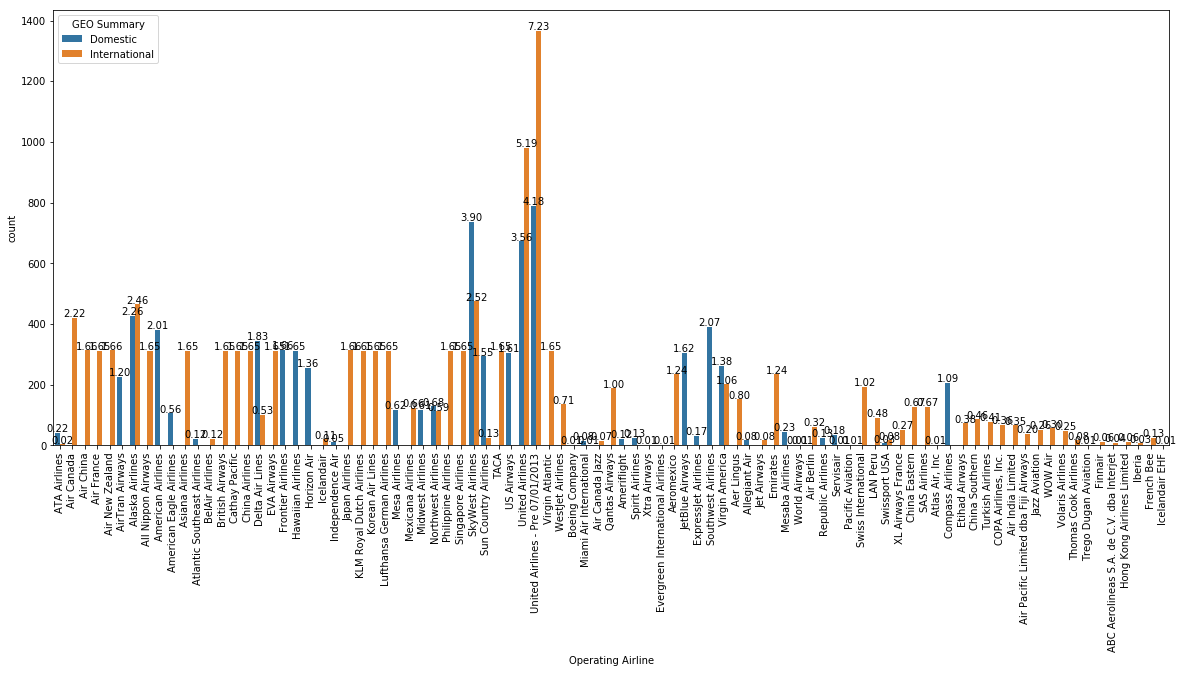

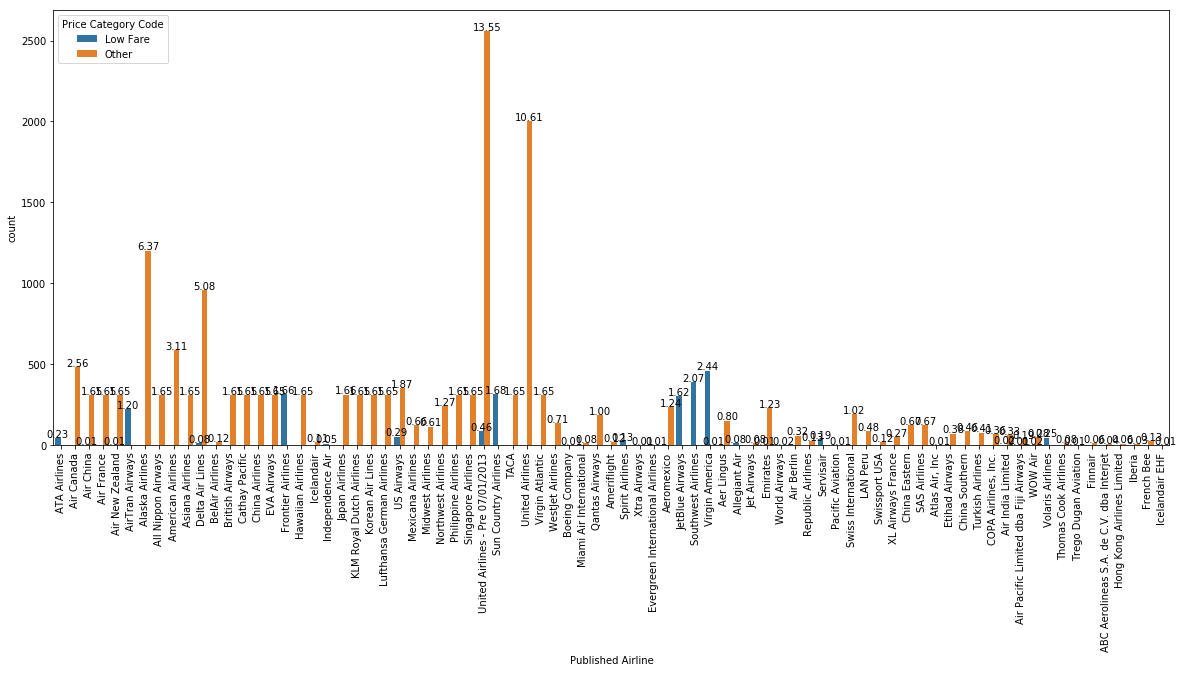

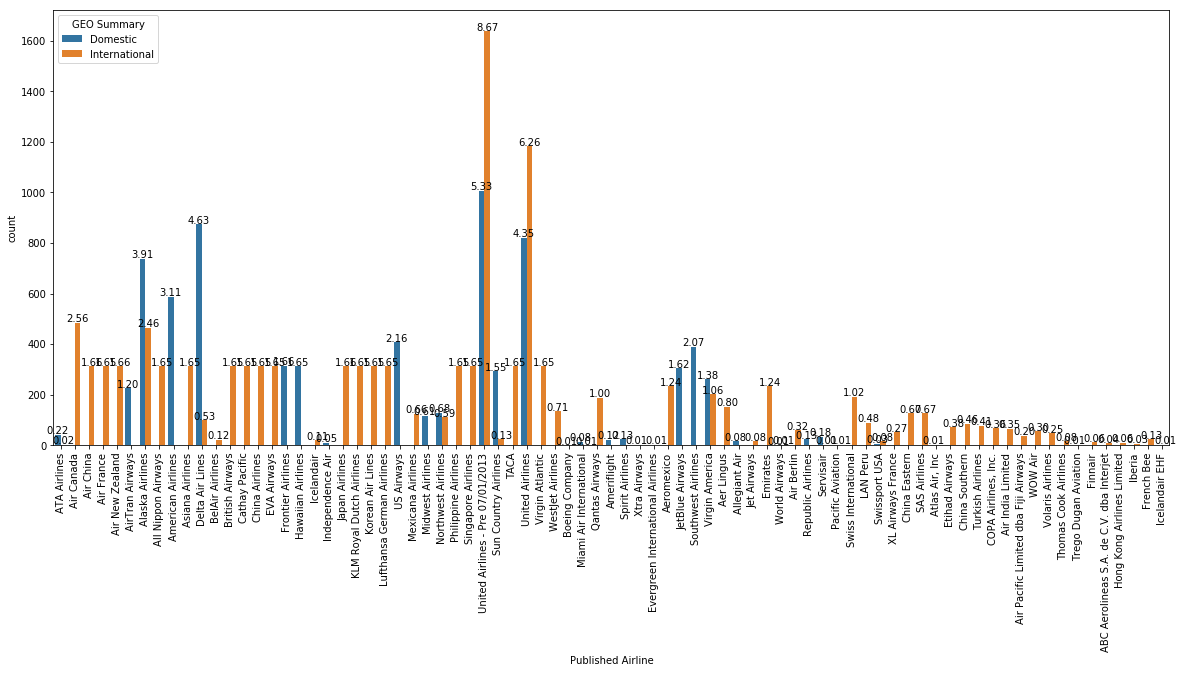

In [11]:
total = float(len(df))
for i in ['Operating Airline','Published Airline']:
    for j in ['Price Category Code','GEO Summary']:
        plt.figure(figsize=(20,8))
        plt.xticks(rotation=90)
        ax = sns.countplot(x=i,hue=j,data=df)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format((height/total)*100),ha="center") 
    plt.show()

In [12]:
df[['Activity Period','Passenger Count']].iplot(kind='box')

# Time Series Forecasting Using LSTM Network

In [13]:
TS = df.groupby("Activity Period")["Passenger Count"].sum().to_frame()

In [14]:
TS.iplot()

In [15]:
s = MinMaxScaler(feature_range=(0,1))
TS = s.fit_transform(TS)

In [16]:

train_size = int(len(TS) * 0.66)
test_size = len(TS) - train_size
train, test = TS[0:train_size,:], TS[train_size:len(TS),:]
print(len(train), len(test))

102 54


In [17]:
def create_dataset(S, look_back=1):
    dataX, dataY = [], []
    for i in range(len(S)-look_back-1):
        a = S[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(S[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=2,validation_data=(testX,testY), verbose=2)

Train on 100 samples, validate on 52 samples
Epoch 1/100
 - 1s - loss: 0.0776 - val_loss: 0.2757
Epoch 2/100
 - 0s - loss: 0.0424 - val_loss: 0.1888
Epoch 3/100
 - 0s - loss: 0.0240 - val_loss: 0.1355
Epoch 4/100
 - 0s - loss: 0.0169 - val_loss: 0.1043
Epoch 5/100
 - 0s - loss: 0.0147 - val_loss: 0.0913
Epoch 6/100
 - 0s - loss: 0.0139 - val_loss: 0.0833
Epoch 7/100
 - 0s - loss: 0.0134 - val_loss: 0.0765
Epoch 8/100
 - 0s - loss: 0.0130 - val_loss: 0.0725
Epoch 9/100
 - 0s - loss: 0.0127 - val_loss: 0.0706
Epoch 10/100
 - 0s - loss: 0.0123 - val_loss: 0.0692
Epoch 11/100
 - 0s - loss: 0.0120 - val_loss: 0.0646
Epoch 12/100
 - 0s - loss: 0.0115 - val_loss: 0.0601
Epoch 13/100
 - 0s - loss: 0.0111 - val_loss: 0.0586
Epoch 14/100
 - 0s - loss: 0.0108 - val_loss: 0.0543
Epoch 15/100
 - 0s - loss: 0.0105 - val_loss: 0.0523
Epoch 16/100
 - 0s - loss: 0.0101 - val_loss: 0.0500
Epoch 17/100
 - 0s - loss: 0.0098 - val_loss: 0.0481
Epoch 18/100
 - 0s - loss: 0.0094 - val_loss: 0.0442
Epoch 19/1

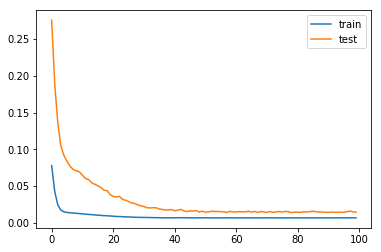

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Changing prediction to it's original units
trainPredict = s.inverse_transform(trainPredict)
trainY = s.inverse_transform([trainY])
testPredict = s.inverse_transform(testPredict)
testY = s.inverse_transform([testY])

trainScore = math.sqrt(mt.mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score = %.2f MSE' % mt.mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train Score =  %.2f RMSE' % (trainScore))
testScore = math.sqrt(mt.mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score = %.2f MSE' % mt.mean_squared_error(testY[0],testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score = 68865203632.48 MSE
Train Score =  262421.80 RMSE
Test Score = 154068134883.09 MSE
Test Score: 392515.14 RMSE


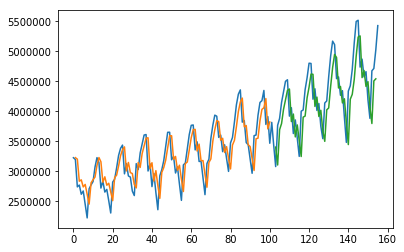

In [23]:
trainPredictPlot = np.empty_like(TS)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(TS)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(TS)-1, :] = testPredict
# plot baseline and predictions
plt.plot(s.inverse_transform(TS))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**Graph Description:** The Blue color represent the original series, whereas the orange represnt the series for train dataset and green for test dataset.